In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text

from PIL import Image
import urllib
import os
import math

In [45]:
plt.style.use('./assets/stylesheets/soc_base.mplstyle')

In [46]:
df = pd.read_csv('data/league_one_xg_xgot.csv',index_col=0)

df_h = (
    df[['home_team_'+x for x in ['name','id','score','xG']]]
    .rename(
        columns={
            'home_team_name':'team_name',
            'home_team_id':'team_id',
            'home_team_score':'score',
            'home_team_xG':'xG',
        }
    )
)

df_a = (
    df[['away_team_'+x for x in ['name','id','score','xG']]]
    .rename(
        columns={
            'away_team_name':'team_name',
            'away_team_id':'team_id',
            'away_team_score':'score',
            'away_team_xG':'xG',
        }
    )
)

data = pd.concat([df_h,df_a]).reset_index(drop=True)
data = data.groupby(['team_name','team_id']).sum().reset_index()
data = data.assign(difference =data['score'] - data['xG'])
data = data.sort_values(by = 'difference').reset_index(drop=True)

In [47]:
gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
# cm.register_cmap(name='SOC', cmap=soc_cm)

In [48]:
def add_logo_on_ax(ax, team_id):
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))    
    ax.imshow(club_icon)
    ax.axis("off")

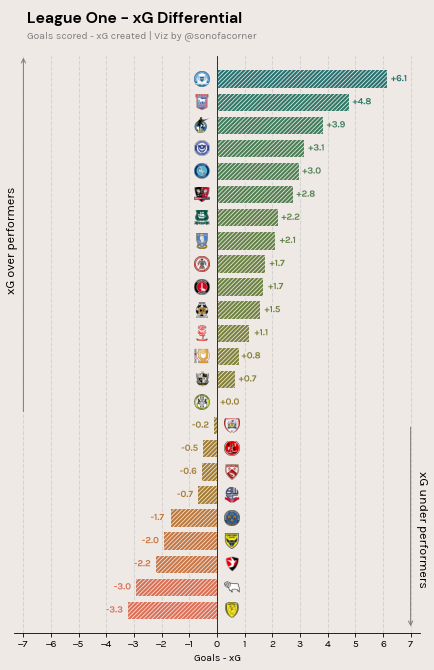

In [50]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()

ax.spines['left'].set_visible(False)
ax.grid(ls='--',lw=1,color='lightgrey',axis='x')
ax.yaxis.set_ticks([])
plt.rcParams['hatch.linewidth']=.75
max_ = max(abs(data['difference'].min()),data['difference'].max())

max_ = max_*1.2
ax.set_xlim(-max_,max_)
ax.set_ylim(-1,data.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Goals - xG', size=10)

norm = mcolors.Normalize(vmin=data['difference'].min(), vmax=data['difference'].max())
cmap = plt.get_cmap('SOC')

ax.barh(data.index, data['difference'],
        hatch='//////', ec='#EFE9E6',
        color = cmap(norm(data['difference'])),
        zorder=3)
ax.plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],color='black',lw=.75,zorder=3)

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

for index, x in enumerate(data['difference']):
    if x < 0:
        sign_offset = -1
        offset_logo = .25
        sign_text = ''
    else:
        sign_offset = 1
        offset_logo = .85
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*12,0),
        text=f'{sign_text}{x:.1f}',
        color= cmap(norm(x)),
        size=9,
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2,
            foreground='#EFE9E6'
        ),
        path_effects.Normal()
    ])
    team_id = data['team_id'].iloc[index]
    ax_coords = DC_to_NFC([sign_offset*(-1)*offset_logo,index-.5])
    logo_ax = fig.add_axes([ax_coords[0],ax_coords[1],.03,.03],anchor="C")
    add_logo_on_ax(logo_ax,team_id)
    
position_negative = data[data['difference'] < 0].index.max()
position_x_negative = math.floor(-max_*(.85))
position_x_positive = math.ceil(max_*(.85))
ax.annotate(
    xy=(position_x_negative,position_negative + .5),
    xytext=(position_x_negative,ax.get_ylim()[1]),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
ax.annotate(
    xy=(position_x_positive,position_negative),
    xytext=(position_x_positive,ax.get_ylim()[0] + .2),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
mid_point_positive = (position_negative + ax.get_ylim()[1])/2
mid_point_negative = (position_negative + ax.get_ylim()[0])/2
ax.annotate(
    xy=(position_x_negative,mid_point_positive),
    text='xG over performers',
    rotation=90,
    xytext=(-10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)
ax.annotate(
    xy=(position_x_positive,mid_point_negative),
    text='xG under performers',
    rotation=-90,
    xytext=(10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)

fig_text(
    x = 0.15, y = .92, 
    s = 'League One - xG Differential',
    va = 'bottom', ha = 'left',
    fontsize = 15, color = 'black', font = 'DM Sans', weight = 'bold'
)

fig_text(
    x = 0.15, y = 0.9, 
    s = 'Goals scored - xG created | Viz by @sonofacorner',
    va = 'bottom', ha = 'left',
    fontsize = 10, color = 'gray'
)